# Pre-Processing of the 2016-ANSAMO Dataset
**Directory:**
    > `Subject_<nr>_ADL_<activity>.csv`
    > ...

**Types of Executed ADLs:**   
1) normal walking, 2) light jogging, 3) body bending, 4) hopping, 5) climbing stairs (up), 6) climbing stairs (down), 7) lying down and getting up from a bed, 8) sitting down (and up) on (from) a chair.

**Columns Units:**  
    After the header, every line in the files corresponds to a measurement captured by a particular mobility sensor of a determined node (mote or SensorTag).  
    The format of the lines, which is also explained in the file header, includes 7 numerical values separated by a semicolon:  
        -The time (in ms) since the experiment began.  
        -The number of the sample (for the same sensor and node).  
        -The three real numbers describing the measurements of the triaxial sensor (x-axis, y-axis and z-axis). The units are g, °/s or μT depending on whether the measurement was performed by an accelerometer, a gyroscope or a magnetometer, respectively.  
        -An integer (0, 1 or 2) describing the type of the sensor that originated the measurement (Accelerometer = 0 , Gyroscope = 1, Magnetometer = 2)  
        -An integer (from 0 to 4) informing about the sensing node (the correspondence between this numerical code and the Bluetooth MAC address and position of the motes is described in the file header).
        
## Desired Dataset Format

current header = TS(ms);SampleNr;X-Axis;Y-Axis;Z-Axis;SensorType;SensorID  
desired header = TS(ms); AccX; AccY; AccZ; MagnX; MagnY; MagnZ; GyroX; GyroY; GyroZ; SubjectID; Gender; Age; Position; Label; and other Feature Extraction Columns (mean, std, corr, etc...)

Pre-Processing Tasks:
    - clean headers information
    - divide the files by subject: "subject_01.csv"; "subject_02.csv"; ... with the desired header above.

In [26]:
## Readme File ##
from IPython.display import IFrame
IFrame("./2016-ANSAMO-Readme.pdf", width=800, height=800)

In [31]:
def download_dataset(path):
    print("downloading dataset...")
    import sys
    sys.path.append('../../../')
    from ipynb.fs.full.Utils import download_from_google_drive
    download_from_google_drive('1fuMxj-dnMXEPHGhHwuQoNjBovO_v5Kdk', path);
    # https://drive.google.com/open?id=1fuMxj-dnMXEPHGhHwuQoNjBovO_v5Kdk
    print("saved at ", path)

In [17]:
def read_file(filepath):
    SUBJECTS = pd.DataFrame([
    {'id': 'Subject 01', 'age':'22', 'gender':'female', 'height':'167', 'weight': '63'},
    {'id': 'Subject 02', 'age':'27', 'gender':'male', 'height':'173', 'weight': '90'},
    {'id': 'Subject 03', 'age':'23', 'gender':'male', 'height':'179', 'weight': '68'}, 
    {'id': 'Subject 04', 'age':'24', 'gender':'male', 'height':'175', 'weight': '79'},
    {'id': 'Subject 05', 'age':'28', 'gender':'male', 'height':'195', 'weight': '81'},
    
    {'id': 'Subject 06', 'age':'22', 'gender':'female', 'height':'167', 'weight': '57'},
    {'id': 'Subject 07', 'age':'55', 'gender':'male', 'height':'170', 'weight': '83'},
    {'id': 'Subject 08', 'age':'19', 'gender':'male', 'height':'178', 'weight': '68'},
    {'id': 'Subject 09', 'age':'26', 'gender':'male', 'height':'176', 'weight': '73'},
    {'id': 'Subject 10', 'age':'51', 'gender':'female', 'height':'155', 'weight': '55'},
    
    {'id': 'Subject 11', 'age':'14', 'gender':'female', 'height':'159', 'weight': '50'},
    {'id': 'Subject 12', 'age':'22', 'gender':'female', 'height':'164', 'weight': '52'},
    {'id': 'Subject 13', 'age':'26', 'gender':'male', 'height':'179', 'weight': '67'},
    {'id': 'Subject 14', 'age':'21', 'gender':'male', 'height':'173', 'weight': '77'},
    {'id': 'Subject 15', 'age':'27', 'gender':'female', 'height':'166', 'weight': '66'},
    
    {'id': 'Subject 16', 'age':'24', 'gender':'male', 'height':'177', 'weight': '66'},
    {'id': 'Subject 17', 'age':'23', 'gender':'female', 'height':'163', 'weight': '93'},
])
    filename = ""
    try:
        filepath.index("/");
        array = filepath.split('/');
        filename = array[len(array) - 1]
    except:
        filename = filepath
    print(filename)
    ## filename = UMAFall_Subject_01_ADL_Bending_1_2016-06-13_20-25-34.csv
    array = filename.split('_')
    subjectID = array[1] + " " + array[2]
    label = array[4]
    experiment = array[4] + "_" + array[5]
    ### read csv
    train_dataRaw = pd.read_csv(filepath)
    ### remove first 31 lines
    train_data = train_dataRaw.iloc[31:]
    ### user characteristics
    user = SUBJECTS[SUBJECTS['id'].isin([subjectID])];
    age = user['age']
    gender = user['gender']
    height = user['height']
    weight = user['weight']

    return {"filecontent": train_data, 
             'experiment': experiment, 
             'label': label, 
             'subjectID': subjectID,
             'filename': filename, 
             'gender': gender.values[0], 
             'age': age.values[0], 
             'height': height.values[0], 
             'weight': weight.values[0]};
   

###output = read_file("../../../datasets/ANSAMO-2016/UMA_ADL_FALL_Dataset/UMAFall_Subject_01_ADL_Bending_1_2016-06-13_20-25-34.csv");

In [18]:
def split_positions_and_signals(filecontent):
    ''' filecontent = pd.DataFrame '''

    ##  Sensor_ID	 Position	 Device Model                                   
    #0	 RIGHTPOCKET	 lge-LG-H815-5.1                                
    #1	 CHEST	 SensorTag
    #2	 WAIST	 SensorTag
    #3	 WRIST	 SensorTag                                            
    #4	 ANKLE	 SensorTag                                                                                                            
    RIGHTPOCKET = '0'
    CHEST = '1'
    WAIST = '2'
    WRIST = '3'
    ANKLE = '4'
    #% Sensor_Type:                                                                     
    #% Accelerometer = 0                                                                
    #% Gyroscope = 1                                                                    
    #% Magnetometer = 2 
    ACCE = '0'
    GYRO = '1'
    MAGN = '2'
    
    ### divide line into several columns
    header_tmp = {'ts(ms)': [], 'SampleNr': [], 'X-Axis': [], 'Y-Axis': [], 'Z-Axis': [], 'SensorType': [] , 'SensorID': []}
    values = pd.DataFrame(data=header_tmp)
    i = 0
    for index, row in filecontent.iterrows():
            line = row[0]
            array = line.split(';')
            if i > 0: values = values.append(pd.DataFrame({'ts(ms)': [array[0]], 'SampleNr': [array[1]], 'X-Axis': [array[2]], 'Y-Axis': [array[3]], 'Z-Axis': [array[4]], 'SensorType': [array[5]] , 'SensorID': [array[6]]}))
            i+=1;
    ### sorting per sensorid, sensortype, and ts
    train_data_processed_ordered = values.sort_values(['SensorID', 'SensorType', 'ts(ms)']);
    ### start splitting into positions and signals
    # divide signals per position
    train_data_pocket = train_data_processed_ordered[train_data_processed_ordered['SensorID'].isin([RIGHTPOCKET])];
    train_data_chest = train_data_processed_ordered[train_data_processed_ordered['SensorID'].isin([CHEST])];
    train_data_waist = train_data_processed_ordered[train_data_processed_ordered['SensorID'].isin([WAIST])];
    train_data_wrist = train_data_processed_ordered[train_data_processed_ordered['SensorID'].isin([WRIST])];
    train_data_ankle = train_data_processed_ordered[train_data_processed_ordered['SensorID'].isin([ANKLE])];
    # pocket 
    pocket_acc = train_data_pocket[train_data_pocket['SensorType'].isin([ACCE])];
    pocket_gyro = train_data_pocket[train_data_pocket['SensorType'].isin([GYRO])];
    pocket_magn = train_data_pocket[train_data_pocket['SensorType'].isin([MAGN])];
    # wrist
    wrist_acc = train_data_wrist[train_data_wrist['SensorType'].isin([ACCE])];
    wrist_gyro = train_data_wrist[train_data_wrist['SensorType'].isin([GYRO])];
    wrist_magn = train_data_wrist[train_data_wrist['SensorType'].isin([MAGN])];
    # ankle
    ankle_acc = train_data_ankle[train_data_ankle['SensorType'].isin([ACCE])];
    ankle_gyro = train_data_ankle[train_data_ankle['SensorType'].isin([GYRO])];
    ankle_magn = train_data_ankle[train_data_ankle['SensorType'].isin([MAGN])];
    # waist
    waist_acc = train_data_waist[train_data_waist['SensorType'].isin([ACCE])];
    waist_gyro = train_data_waist[train_data_waist['SensorType'].isin([GYRO])];
    waist_magn = train_data_waist[train_data_waist['SensorType'].isin([MAGN])];
    # chest
    chest_acc = train_data_chest[train_data_chest['SensorType'].isin([ACCE])];
    chest_gyro = train_data_chest[train_data_chest['SensorType'].isin([GYRO])];
    chest_magn = train_data_chest[train_data_chest['SensorType'].isin([MAGN])];
    
    return {'pocket_acc':pocket_acc,
           'pocket_gyro':pocket_gyro,
           'pocket_magn':pocket_magn,
           
           'wrist_acc':wrist_acc,
           'wrist_gyro':wrist_gyro,
           'wrist_magn':wrist_magn,
           
           'ankle_acc':ankle_acc,
           'ankle_gyro':ankle_gyro,
           'ankle_magn':ankle_magn,
           
           'waist_acc':waist_acc,
           'waist_gyro':waist_gyro,
           'waist_magn':waist_magn,
           
           'chest_acc':chest_acc,
           'chest_gyro':chest_gyro,
           'chest_magn':chest_magn,
           
            'train_data_pocket':train_data_pocket,
            'train_data_chest':train_data_chest,
            'train_data_waist':train_data_waist,
            'train_data_wrist':train_data_wrist,
            'train_data_ankle':train_data_ankle,
           };

##filecontent = pd.DataFrame(output['filecontent']);
##values = split_positions_and_signals(filecontent);

In [19]:
def join_all_signals_types(signals, info):
    ''' Receives the argument: 
    sigmals = pd.DataFrame([
    {   'value': pocket_acc, 'signalType': 'acc'},  {'value': pocket_gyro, 'signalType': 'gyro'}, ... 
    info = pd.DataFrame([{
        'userGender': 'male',
        'userAge': '55',
        'userID':'sdasd'
        'position': 2
        'filename': 'asda.csv',
        'experiment': 'Bending_1',
        'label': 'Bending'}]) 
    '''
    userAge = info['userAge']
    userGender = info['userGender']
    userID = info['userID']
    label = info['label']
    filename = info['filename']
    experiment = info['experiment']
    
    header = [ 'ts(ms)', 'accX', 'accY', 'accZ',
              'magX', 'magY', 'magZ',
              'gyrX', 'gyrY', 'gyrZ',
              'userGender', 'userAge', 'userID',
              'position', 
              'label',
              'filename',
              'experiment' ];
    all_values = pd.DataFrame(columns=header);
    
    for indexR, lineR in signals.iterrows():
        array = lineR['value'];
        signalType = lineR['signalType'];
        position = lineR['position'];
        
        for index, line in array.iterrows():
            row = all_values[all_values['ts(ms)'] == line['ts(ms)']];
            ts_tmp = [line['ts(ms)']];
            
            if signalType is "acc": 
                 acc_values_tmp = [ [line['X-Axis']] ,  [line['Y-Axis']],  [line['Z-Axis']]];
                 magn_values_tmp = [ [-1] ,  [-1],  [-1]];
                 gyro_values_tmp = [ [-1] ,  [-1],  [-1]]; 
            elif signalType is "magn":
                 acc_values_tmp = [ [-1] ,  [-1],  [-1]]; 
                 magn_values_tmp = [ [line['X-Axis']] ,  [line['Y-Axis']],  [line['Z-Axis']]];
                 gyro_values_tmp = [ [-1] ,  [-1],  [-1]]; 
            else:
                acc_values_tmp = [ [-1] ,  [-1],  [-1]];    
                magn_values_tmp = [ [-1] ,  [-1],  [-1]];
                gyro_values_tmp = [ [line['X-Axis']] ,  [line['Y-Axis']],  [line['Z-Axis']]];      

            if row.size == 0:
                all_values = all_values.append(pd.DataFrame({'ts(ms)': ts_tmp, 
                                    'accX':acc_values_tmp[0],
                                    'accY':acc_values_tmp[1],
                                    'accZ': acc_values_tmp[2], 
                                    'magX':magn_values_tmp[0],
                                    'magY':magn_values_tmp[1], 
                                    'magZ': magn_values_tmp[2], 
                                    'gyrX':gyro_values_tmp[0],
                                    'gyrY': gyro_values_tmp[1],
                                    'gyrZ': gyro_values_tmp[2], 
                                    'userGender': userGender, 
                                    'userAge': userAge, 
                                    'userID': userID,
                                    'position': position, 
                                    'label':label.values,
                                    'filename':filename,
                                    'experiment': experiment}))
            else:
                row.at[index, 'accX'] = acc_values_tmp[0];
                row.at[index, 'accY'] = acc_values_tmp[1];
                row.at[index, 'accZ'] = acc_values_tmp[2];
                
                row.at[index, 'gyrX'] = gyro_values_tmp[0];
                row.at[index, 'gyrY'] = gyro_values_tmp[1];
                row.at[index, 'gyrZ'] = gyro_values_tmp[2];
                
                row.at[index, 'magZ'] = magn_values_tmp[2];
                row.at[index, 'magZ'] = magn_values_tmp[2];
                row.at[index, 'magZ'] = magn_values_tmp[2];
                
    return all_values;

###
###signals = pd.DataFrame([{'value': wrist_gyro, 'signalType': 'gyro'}])
###all_values = join_all_signals_types(signals)
###print("len of all values:", len(all_values));

In [20]:
def process_file(filePath):
    ### read file
    output = read_file(filePath)
    filecontent = pd.DataFrame(output['filecontent']);
    ###
    experiment = output['experiment'];
    label = output['label'];
    subjectID = output['subjectID'];
    filename = output['filename'];
    gender = output['gender'];
    age = output['age'];
    height = output['height'];
    weight = output['weight'];
    info = pd.DataFrame([{
        'userGender': gender,
        'userAge': age,
        'userID': subjectID,
        'filename': filename,
        'experiment': experiment,
        'label': label
    }])
    ### split into positions and signal type
    values = split_positions_and_signals(filecontent);
    ### 
    pocket_acc = values['pocket_acc']
    pocket_gyro = values['pocket_gyro']
    pocket_magn = values['pocket_magn']

    wrist_acc = values['wrist_acc']
    wrist_gyro = values['wrist_gyro']
    wrist_magn = values['wrist_magn']

    ankle_acc = values['ankle_acc']
    ankle_gyro = values['ankle_gyro']
    ankle_magn = values['ankle_magn']

    waist_acc = values['waist_acc']
    waist_gyro = values['waist_gyro']
    waist_magn = values['waist_magn']

    chest_acc = values['chest_acc']
    chest_gyro = values['chest_gyro']
    chest_magn = values['chest_magn']

    signalsPocket = pd.DataFrame(
        [
         {'value': pocket_acc, 'signalType': 'acc', 'position': 'pocket'},
         {'value': pocket_gyro, 'signalType': 'gyro', 'position': 'pocket'},
         {'value': pocket_magn, 'signalType': 'magn', 'position': 'pocket'},
        ]);

    signalsAnkle = pd.DataFrame(
        [
        {'value': ankle_acc, 'signalType': 'acc', 'position': 'ankle'},
        {'value': ankle_gyro, 'signalType': 'gyro', 'position': 'ankle'},
        {'value': ankle_magn, 'signalType': 'magn', 'position': 'ankle'},
        ]);

    signalsWrist = pd.DataFrame(
        [
         {'value': wrist_acc, 'signalType': 'acc', 'position': 'wrist'},
         {'value': wrist_gyro, 'signalType': 'gyro', 'position': 'wrist'},
         {'value': wrist_magn, 'signalType': 'magn', 'position': 'wrist'},
        ]);

    signalsWaist = pd.DataFrame(
        [
        {'value': waist_acc, 'signalType': 'acc', 'position': 'waist'},
        {'value': waist_gyro, 'signalType': 'gyro', 'position': 'waist'},
        {'value': waist_magn, 'signalType': 'magn', 'position': 'waist'},
        ]);

    signalsChest = pd.DataFrame(
        [
        {'value': chest_acc, 'signalType': 'acc', 'position': 'chest'},
        {'value': chest_gyro, 'signalType': 'gyro', 'position': 'chest'},
        {'value': chest_magn, 'signalType': 'magn', 'position': 'chest'},
        ]);
    ### join all values
    all_values = join_all_signals_types(signalsPocket, info);
    all_values = all_values.append(join_all_signals_types(signalsAnkle, info))
    all_values = all_values.append(join_all_signals_types(signalsWrist, info))
    all_values = all_values.append(join_all_signals_types(signalsWaist, info))
    all_values = all_values.append(join_all_signals_types(signalsChest, info))
    
    return all_values;

In [21]:
from ipynb.fs.full.Utils import download_from_google_drive
help(download_from_google_drive)

Help on function download_from_google_drive in module ipynb.fs.full.Utils:

download_from_google_drive(id, destPath)
    This function downloads Google Drive Shared Files By Passing Its Sharing Link And The Desired Destination Path



In [36]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys, subprocess
dependencies = ['ipynb', 'googledrivedownloader']
subprocess.call([sys.executable, '-m', 'pip', 'install'] + dependencies)

download_dataset("./Dataset/ansamo.zip");
print("Please Unzip File... Press Enter When Done.");
yourvar = input('Choose a number: ')
base_path = './Dataset/ansamo/UMA_ADL_FALL_Dataset/'
files = os.listdir(base_path)
total = pd.DataFrame();
for file in files:
    if '.csv' in file:
        print("processing file: " + base_path + "/" + file + " wait...")
        filePath = base_path+"/"+file;
        values = process_file(filePath);
        total = total.append(values)

total.to_csv("all_values.csv", sep=',')
print("done!")   

downloading dataset...
The File Already Exists. Please Change The Path Destination.
saved at  ./Dataset/ansamo.zip
Please Unzip File... Press Enter When Done.
Choose a number: 
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_01_ADL_Bending_1_2016-06-13_20-25-34.csv wait...
UMAFall_Subject_01_ADL_Bending_1_2016-06-13_20-25-34.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_01_ADL_Bending_2_2016-06-13_20-26-15.csv wait...
UMAFall_Subject_01_ADL_Bending_2_2016-06-13_20-26-15.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_01_ADL_Bending_3_2016-06-13_20-26-59.csv wait...
UMAFall_Subject_01_ADL_Bending_3_2016-06-13_20-26-59.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_01_ADL_forwardFall_1_2016-06-13_20-43-52.csv wait...
UMAFall_Subject_01_ADL_forwardFall_1_2016-06-13_20-43-52.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_01_ADL_Hopping_1_2016-06-13_20-

processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_02_ADL_Hopping_3_2016-06-13_13-02-19.csv wait...
UMAFall_Subject_02_ADL_Hopping_3_2016-06-13_13-02-19.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_02_ADL_Jogging_1_2016-06-13_13-07-16.csv wait...
UMAFall_Subject_02_ADL_Jogging_1_2016-06-13_13-07-16.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_02_ADL_Jogging_2_2016-06-13_13-07-58.csv wait...
UMAFall_Subject_02_ADL_Jogging_2_2016-06-13_13-07-58.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_02_ADL_Jogging_3_2016-06-13_13-08-41.csv wait...
UMAFall_Subject_02_ADL_Jogging_3_2016-06-13_13-08-41.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_02_ADL_LyingDown_OnABed_1_2016-06-13_13-10-22.csv wait...
UMAFall_Subject_02_ADL_LyingDown_OnABed_1_2016-06-13_13-10-22.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_02_ADL_LyingDown_OnA

KeyboardInterrupt: 

# Feature Extraction of the 2016-ANSAMO Dataset
**Directory:**
    > `Subject_<nr>_ADL_<activity>.csv`
    > ...

**Types of Executed ADLs:**   
1) normal walking, 2) light jogging, 3) body bending, 4) hopping, 5) climbing stairs (up), 6) climbing stairs (down), 7) lying down and getting up from a bed, 8) sitting down (and up) on (from) a chair.

**Columns Units:**  
    After the header, every line in the files corresponds to a measurement captured by a particular mobility sensor of a determined node (mote or SensorTag).  
    The format of the lines, which is also explained in the file header, includes 7 numerical values separated by a semicolon:  
        -The time (in ms) since the experiment began.  
        -The number of the sample (for the same sensor and node).  
        -The three real numbers describing the measurements of the triaxial sensor (x-axis, y-axis and z-axis). The units are g, °/s or μT depending on whether the measurement was performed by an accelerometer, a gyroscope or a magnetometer, respectively.  
        -An integer (0, 1 or 2) describing the type of the sensor that originated the measurement (Accelerometer = 0 , Gyroscope = 1, Magnetometer = 2)  
        -An integer (from 0 to 4) informing about the sensing node (the correspondence between this numerical code and the Bluetooth MAC address and position of the motes is described in the file header).

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
base_path = "./Dataset/ansamo/";

In [43]:
###
### Read CSV File
###
all_values = pd.read_csv(base_path + "all_values.csv");
all_values.dtypes

Unnamed: 0      int64
accX          float64
accY          float64
accZ          float64
experiment     object
filename       object
gyrX          float64
gyrY          float64
gyrZ          float64
label          object
magX          float64
magY          float64
magZ          float64
position       object
ts(ms)          int64
userAge         int64
userGender     object
userID         object
dtype: object

In [41]:
###
###
###
print("nr of instances:", len(all_values))
list_of_users = list(set(all_values['userID']))
print("nr of users: ", len(list_of_users))
ageDistribution = list(set(all_values['userAge']))
print("age distribution", ageDistribution)
labels = list(set(all_values['label']))
print("labels:", labels)
print("\nusers :", list(set(all_values['userID'])))

nr of instances: 2843028
nr of users:  17
age distribution [14, 19, 51, 55, 22, 23, 24, 21, 26, 27, 28]
labels: ['lateralFall', 'GoDownstairs', 'forwardFall', 'Hopping', 'Sitting', 'Walking', 'Jogging', 'GoUpstairs', 'backwardFall', 'Bending', 'LyingDown']

users : ['Subject 15', 'Subject 06', 'Subject 08', 'Subject 02', 'Subject 01', 'Subject 14', 'Subject 09', 'Subject 07', 'Subject 12', 'Subject 03', 'Subject 17', 'Subject 04', 'Subject 10', 'Subject 16', 'Subject 13', 'Subject 05', 'Subject 11']


In [44]:
###
### Each User With A Separate File
###
users = list(set(all_values['userID']));

for line in users:
    subject_index = all_values[all_values['userID'].isin([line])]
    print(line, " " , len(subject_index))
    subject_index.to_csv(base_path + "_" + line + ".csv");

Subject 15   128784
Subject 06   61969
Subject 08   85714
Subject 02   183943
Subject 01   236210
Subject 14   67276
Subject 09   221925
Subject 07   93653
Subject 12   167738
Subject 03   227716
Subject 17   150759
Subject 04   235954
Subject 10   90067
Subject 16   555730
Subject 13   117225
Subject 05   129682
Subject 11   88683


In [45]:
from math import fabs
def sliding_window(values, time_interval_ms, time_interval_unc):
    ''' ( values, time_interval_ms, time_interval_unc)
    '''
    old_ts = 0;
    old_acc = [-1,-1,-1];
    old_gyr = [-1,-1,-1];
    old_mag = [-1,-1,-1];
    header = [ 'Its(ms)', 'Fts(ms)',
                  'accX', 'accY', 'accZ',
                  'magX', 'magY', 'magZ',
                  'gyrX', 'gyrY', 'gyrZ',
                  'userGender', 'userAge', 'userID',
                  'position', 
                  'label',
                  'filename',
                  'experiment' ];
    final_values = pd.DataFrame(columns=header);
    values = values.sort_values(['ts(ms)']);

    for index, line in values.iterrows():
        ts = line['ts(ms)']
        acc = [ line['accX'], line['accY'],  line['accZ']]
        gyr = [ line['gyrX'], line['gyrY'],  line['gyrZ']]
        mag = [ line['magX'], line['magY'],  line['magZ']]
        if acc[0] != -1:
            old_acc = acc;
        if gyr[0] != -1:
            old_gyr = gyr;
        if mag[0] != -1:
            old_mag = mag;    
        diff = ts - old_ts;
        
        if diff < 0:
            raise ValueError('The List Is Not Sorted By Time!!!') 

        if diff == time_interval_ms or fabs(diff - time_interval_ms) <= time_interval_unc:
            final_values = final_values.append(pd.DataFrame([{
                 'Its(ms)': old_ts, 'Fts(ms)': ts,
                  'accX': old_acc[0], 'accY': old_acc[1], 'accZ': old_acc[2],
                  'magX': old_mag[0], 'magY': old_mag[1], 'magZ': old_mag[2],
                  'gyrX': old_gyr[0], 'gyrY': old_gyr[1], 'gyrZ': old_gyr[2],
                  'userGender': line['userGender'], 'userAge': line['userAge'], 'userID': line['userID'],
                  'position': line['position'], 
                  'label': line['label'],
                  'filename': line['filename'],
                  'experiment': line['experiment']}]));
            old_ts = ts;
        elif diff > time_interval_ms:
            old_ts = ts;
    return final_values;

In [46]:
time_interval_ms = 50;
time_interval_unc = 10;
final_array = pd.DataFrame()
# users
for line in users:
    subject = all_values[all_values['userID'].isin([line])]
    print(line, ", ", len(subject))
    #experiments
    experiments = list(set(subject['experiment']))
    for lineExp in experiments:
        subject_exp = subject[subject['experiment'].isin([lineExp])]        
        #positions
        positions = list(set(subject_exp['position']))
        for linePos in positions:
            subject_exp_pos = subject_exp[subject_exp['position'].isin([linePos])]
            final_array = final_array.append(sliding_window(subject_exp_pos, time_interval_ms, time_interval_unc));      
    print(len(final_array));
    
final_array.to_csv("all_users_50ms.csv");

Subject 15 ,  128784
24517
Subject 06 ,  61969
37345
Subject 08 ,  85714
49534
Subject 02 ,  183943
86232
Subject 01 ,  236210
131923
Subject 14 ,  67276
145530
Subject 09 ,  221925
191602
Subject 07 ,  93653
204519
Subject 12 ,  167738
230380
Subject 03 ,  227716
275029
Subject 17 ,  150759
296652
Subject 04 ,  235954
340987
Subject 10 ,  90067
353839
Subject 16 ,  555730
442063
Subject 13 ,  117225
465782
Subject 05 ,  129682
490707
Subject 11 ,  88683
503779


In [5]:
all_values = pd.read_csv(base_path + "t1-2_all_users_50ms.csv");

In [12]:
# Remove pocket signals, falling labels, lines with incomplete signal values

# Remove pocket signals
positions = list(set(all_values['position']))
print(positions)
print("all signals: ", len(all_values));
all_values = all_values[~all_values['position'].isin(['pocket'])];
print("non-pocket signals: ", len(all_values));

['ankle', 'waist', 'chest', 'wrist']
all signals:  361149
non-pocket signals:  361149


In [17]:
# Remove falling labels except Sitting, GoUpstairs, Bending, Walking, Jogging, Hoping, GoDownstairs
labels = list(set(all_values['label']))
print(labels)
desired_labels = ['Sitting', 'Bending', 'Walking', 'Jogging', 'Hopping', 
                  'GoUpstairs', 'GoDownstairs']
all_values_2 = all_values[all_values['label'].isin(desired_labels)];
print(len(all_values))
print(len(all_values_2))

['LyingDown', 'Sitting', 'forwardFall', 'lateralFall', 'backwardFall', 'GoUpstairs', 'Bending', 'Walking', 'Jogging', 'Hopping', 'GoDownstairs']
361149
175375
['Sitting', 'GoUpstairs', 'Bending', 'Walking', 'Jogging', 'Hopping', 'GoDownstairs']


In [47]:
positions = list(set(all_values_2['position']))
print(positions)
labels = list(set(all_values_2['label']))
print(labels)
age = list(set(all_values_2['userAge']))
print(age)

old = all_values_2[all_values_2['userAge'].isin(['55'])];
labels = list(set(old['label']))
print(labels)

old = all_values_2[all_values_2['userAge'].isin(['51'])];
labels = list(set(old['label']))
print(labels)
all_values_2.head(0)

['ankle', 'waist', 'chest', 'wrist']
['Sitting', 'GoUpstairs', 'Bending', 'Walking', 'Jogging', 'Hopping', 'GoDownstairs']
[14, 19, 23, 21, 22, 55, 24, 51, 26, 27, 28]
['Sitting', 'GoUpstairs', 'Bending', 'Walking', 'GoDownstairs', 'Hopping']
['Sitting', 'GoUpstairs', 'Bending', 'Walking', 'GoDownstairs', 'Hopping']


,Unnamed: 0,Fts(ms),Its(ms),accX,accY,accZ,experiment,filename,gyrX,gyrY,gyrZ,label,magX,magY,magZ,position,userAge,userGender,userID


In [33]:
# remove lines with incomplete signal values
incomple_lines = 0
for index, line in all_values_2.iterrows():
    if line['accX'] == -1 and line['gyrX'] == -1 and line['magX'] == -1:
        incomple_lines +=1;
print(len(all_values_2) , " vs. " , incomple_lines)

175375  vs.  0


In [34]:
all_values_2.to_csv("t1-3_all_values_50ms.csv");

In [48]:
all_values_2.describe()

,Unnamed: 0,Fts(ms),Its(ms),accX,accY,accZ,gyrX,gyrY,gyrZ,magX,magY,magZ,userAge
count,175375.0,175375.000000,175375.00000,175375.000000,175375.000000,175375.000000,175375.000000,175375.000000,175375.000000,175375.000000,175375.000000,175375.000000,175375.000000
mean,0.0,7505.649488,7457.47147,0.600532,-0.055701,0.075002,-2.126005,-0.171710,-0.794811,-11.509510,-7.031505,-28.754855,26.158227
std,0.0,4208.938001,4209.05653,0.935383,0.462584,0.525032,65.190146,69.084292,51.765024,65.091665,58.132460,101.711870,8.727373
min,0.0,50.000000,0.00000,-6.892090,-8.000000,-7.937256,-256.898438,-257.000000,-256.828125,-187.500000,-192.000000,-234.666672,14.000000
25%,0.0,3850.000000,3801.00000,0.125977,-0.184570,-0.107178,-14.554688,-13.500000,-8.398438,-59.500000,-19.333334,-107.333336,22.000000
50%,0.0,7472.000000,7424.00000,0.918945,-0.050049,0.089600,-1.718750,-0.281250,-1.148438,-12.500000,-1.500000,-26.166666,24.000000
75%,0.0,11065.000000,11017.00000,1.007324,0.068359,0.297363,10.558594,10.500000,7.101562,38.166668,33.333332,50.833332,27.000000
max,0.0,15036.000000,14982.00000,8.000000,7.937256,8.000000,254.992188,254.812500,254.898438,146.833328,98.333336,218.500000,55.000000


## Experiment

In [76]:
all_values = pd.read_csv("t1-3_all_values_50ms.csv");

13998
13998
1105
280
280
13998
count    280.000000
mean       0.944008
std        0.203904
min        0.525391
25%        0.811096
50%        0.924194
75%        1.034241
max        1.889648
Name: accX, dtype: float64


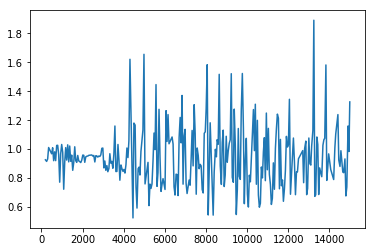

In [111]:
# filter by user, experiment, and position
print(len(subject01))
subject01 = all_values_2[all_values_2['userID'].isin(['Subject 01'])];
print(len(subject01))
# experiments: ['Hopping_2', 'Walking_2', 'Bending_2', 'Hopping_1', 'Walking_3', 'Hopping_3', 'Jogging_3', 'Bending_3', 'Bending_1', 'Jogging_1', 'Jogging_2', 'Sitting_GettingUpOnAChair', 'Walking_1']
subject01_exp = subject01[subject01['experiment'].isin(['Walking_2'])];
print(len(subject01_exp))
# positions: ['ankle', 'waist', 'chest', 'wrist']
subject01_exp_pos = subject01_exp[subject01_exp['position'].isin(['waist'])];
print(len(subject01_exp_pos))
subject01_exp_pos_sor = subject01_exp_pos.sort_values(['Fts(ms)'])
accX = subject01_exp_pos_sor['accX']
time = subject01_exp_pos_sor['Fts(ms)']
print(len(accX))
print(len(ts))
print(accX.describe())
time.describe()
ts = pd.Series(accX.values, index=time.values)
%matplotlib inline
ts.plot()

13998
13998
1105
280


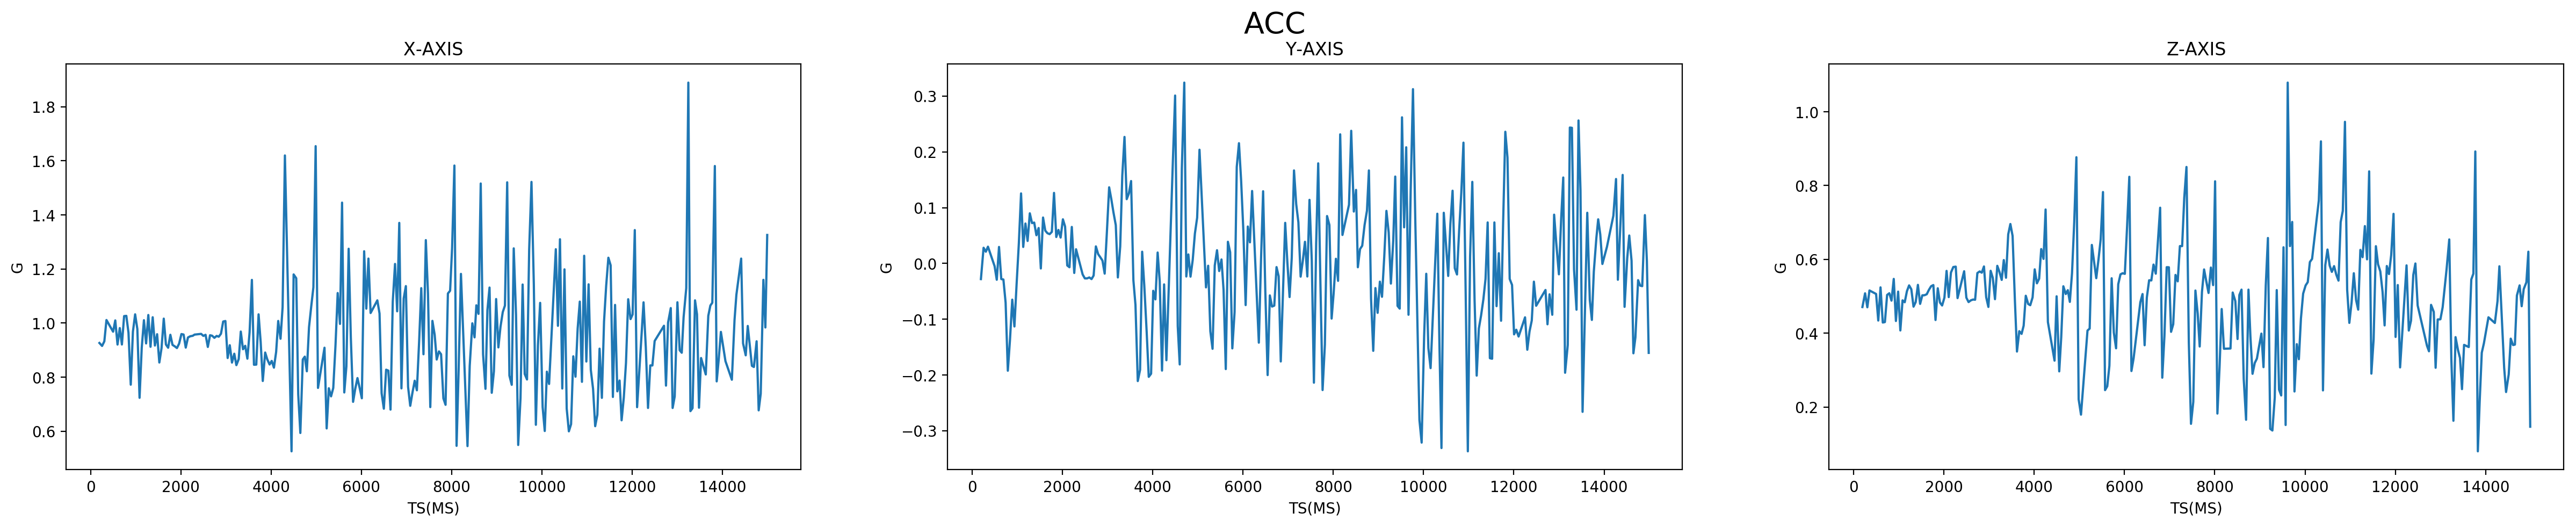

In [123]:
subject01 = all_values_2[all_values_2['userID'].isin(['Subject 01'])];
# filter by user, experiment, and position
print(len(subject01))
subject01 = all_values_2[all_values_2['userID'].isin(['Subject 01'])];
print(len(subject01))
# experiments: ['Hopping_2', 'Walking_2', 'Bending_2', 'Hopping_1', 'Walking_3', 'Hopping_3', 'Jogging_3', 'Bending_3', 'Bending_1', 'Jogging_1', 'Jogging_2', 'Sitting_GettingUpOnAChair', 'Walking_1']
subject01_exp = subject01[subject01['experiment'].isin(['Walking_2'])];
print(len(subject01_exp))
# positions: ['ankle', 'waist', 'chest', 'wrist']
subject01_exp_pos = subject01_exp[subject01_exp['position'].isin(['waist'])];
print(len(subject01_exp_pos))

subject01_exp_pos_sor = subject01_exp_pos.sort_values(['Fts(ms)'])

time = subject01_exp_pos_sor['Fts(ms)'].values
sensorX_y = subject01_exp_pos_sor['accX'].values;
sensorY_y = subject01_exp_pos_sor['accY'].values;
sensorZ_y = subject01_exp_pos_sor['accZ'].values;
fig_title = "ACC"
label_y = "G"
label_x = "TS(MS)"
destPath = "demo.jpg"
create_figure(time,sensorX_y, sensorY_y, sensorZ_y, fig_title, label_x, label_y, destPath);

In [118]:
def create_figure(time , sensorX_y, sensorY_y, sensorZ_y, 
                 fig_title,
                 label_x,
                 label_y,
                destPath):
    
    import pylab as plt
    import numpy as np
    fig ,axs=plt.subplots(1,3)
    fig.set_size_inches(30, 5, forward=True)
    fig.set_dpi(200)
    ax=axs.ravel()
    ax[0].plot(time, sensorX_y)
    ax[1].plot(time, sensorY_y)
    ax[2].plot(time, sensorZ_y)
    
    ax[0].set_title("X-AXIS")
    ax[0].set_ylabel(label_y)
    ax[0].set_xlabel(label_x)

    ax[1].set_title("Y-AXIS")
    ax[1].set_ylabel(label_y)
    ax[1].set_xlabel(label_x)
    
    ax[2].set_title("Z-AXIS")
    ax[2].set_ylabel(label_y)
    ax[2].set_xlabel(label_x)

    fig.suptitle(fig_title, fontsize=20)
    fig.savefig(destPath)
    return fig;

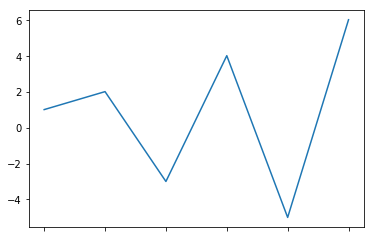

In [68]:
ts = pd.Series([1,2,-3,4,-5,6], index=['walk', 'walk', 'walk', 'walk', 'walk5', 'walk6'])
%matplotlib inline
ts.plot(x="lib")

In [61]:
def confirm_incomplete_lines(array):
    i = 0
    for index, line in array.iterrows():
        if line['accX'] != -1 and line['gyrX'] != -1 and line['magX'] != -1:
            i+=1 
    if i+1 < len(array): 
        print("Position:", array['position'], 
              "Subject: ", array['userID'], 
              len(array), " vs. ", i)
        return False;
    else: 
        return True;
    
# users
users = list(set(all_values['userID']));
for line in users:
    subject = all_values[all_values['userID'].isin([line])]
    #print(line, ", ", len(subject))
    #experiments
    experiments = list(set(subject['experiment']))
    for lineExp in experiments:
        subject_exp = subject[subject['experiment'].isin([lineExp])]        
        #positions
        positions = list(set(subject_exp['position']))
        for linePos in positions:
            subject_exp_pos = subject_exp[subject_exp['position'].isin([linePos])]
            if linePos != "pocket": 
                confirm_incomplete_lines(subject_exp_pos);
            
#subject_01_data = all_values[all_values['userID'].isin(['Subject 01'])]
#subject_01_data_bending_1 = subject_01_data[subject_01_data['experiment'].isin(['Bending_1'])]
#subject_01_data_bending_1_waist = subject_01_data_bending_1[subject_01_data_bending_1['position'].isin(['ankle'])]
#subject_01_data_bending_1_waist_acc = subject_01_data_bending_1[~subject_01_data_bending_1['accX'].isin([-1])]
#subject_01_data_bending_1_waist_gyr = subject_01_data_bending_1[~subject_01_data_bending_1['gyrX'].isin([-1])]
#subject_01_data_bending_1_waist_gyr = subject_01_data_bending_1_waist_gyr.sort_values['ts(ms)']

#i = 0
#for index, line in subject_01_data_bending_1_waist.iterrows():
#    if line['accX'] != -1 and line['gyrX'] != -1 and line['magX'] != -1:
#        i+=1

#print(subject_01_data_bending_1_waist['accX'].describe())
#delta_ts(subject_01_data_bending_1_waist_acc).describe()
#delta_ts(subject_01_data_bending_1_waist_gyr).describe()
#print(subject_01_data_bending_1_waist['gyrX'].describe())
#print(subject_01_data_bending_1_waist['magX'].describe())
#print(len(subject_01_data_bending_1_waist))
#print("i:", i)

In [80]:
#print(final_array.dtypes)
waist = final_array[final_array['position'].isin(['waist'])]
#waist = waist.sort_values(['Its(ms)'])
i = 0
for index, line in waist.iterrows():
    if line['accX'] != -1 and line['gyrX'] != -1 and line['magX'] != -1:
        i+=1;
print(len(waist))
print("i:", i)

24177
i: 7


In [43]:
subject_01_data = all_values[all_values['userID'].isin(['Subject 01'])]
### Sort In Experiments
list(set(subject_01_data['experiment']))

subject_01_data_bending_1 = subject_01_data[subject_01_data['experiment'].isin(['Bending_1'])]
len(subject_01_data_bending_1)

position = list(set(subject_01_data_bending_1['position']))
subject_01_data_bending_1_waist = subject_01_data_bending_1[subject_01_data_bending_1['position'].isin(['waist'])]
len(subject_01_data_bending_1_waist)

867

In [104]:
###
### Analysis Only Of Ts Column
###
def delta_ts(array):
    old_ts = 0;
    array = array.sort_values(['ts(ms)'])
    deltas_ts = pd.DataFrame({'delta_ts':[]})
    for index, line in array.iterrows():
        ts = line['ts(ms)']
        if old_ts > ts:
            print("fuck! current ts:", ts, " and old ts:", old_ts)
            break
        delta_ts = ts - old_ts;
        deltas_ts = deltas_ts.append(pd.DataFrame({'delta_ts':[delta_ts]}))
        old_ts = ts;
    return deltas_ts;

In [3]:
subject_01_data = all_values[all_values['userID'].isin(['Subject 01'])]
### Sort In Experiments
list(set(subject_01_data['experiment']))
### Sort In Position

print(len(subject_01_data))
###
### Analysis Only Of Ts Column
###
old_ts = 0;
subject_01_data = subject_01_data.sort_values(['ts(ms)'])
deltas_ts = pd.DataFrame({'delta_ts':[]})
for index, line in subject_01_data.iterrows():
    ts = line['ts(ms)']
    if old_ts > ts:
        print("fuck current ts:", ts, " and old ts:", old_ts)
        break
    delta_ts = ts - old_ts;
    deltas_ts = deltas_ts.append(pd.DataFrame({'delta_ts':[delta_ts]}))
    old_ts = ts;

deltas_ts.describe()

236210


,delta_ts
count,236210.000000
mean,0.063532
std,0.280685
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,67.000000


,id,time,F_x,F_y,F_z,T_x,T_y,T_z
count,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000
mean,44.500000,7.000000,-2.345455,8.913636,-128.214394,-39.028030,-4.517424,0.868182
std,25.411399,4.322131,50.367960,45.845475,346.816091,147.269399,101.609308,18.317250
min,1.000000,0.000000,-260.000000,-353.000000,-1547.000000,-672.000000,-646.000000,-137.000000
25%,22.750000,3.000000,-4.000000,-2.000000,-117.250000,-39.250000,-13.000000,-1.000000
50%,44.500000,7.000000,-1.000000,1.000000,46.000000,-9.000000,-3.000000,0.000000
75%,66.250000,11.000000,3.000000,11.000000,60.000000,-1.000000,3.000000,2.000000
max,88.000000,14.000000,342.000000,236.000000,157.000000,686.000000,601.000000,123.000000


Feature Extraction: 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


Feature Extraction: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]
 'F_x__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'F_x__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"' ...
 'T_z__fft_coefficient__coeff_9__attr_"imag"'
 'T_z__fft_coefficient__coeff_9__attr_"real"'
 'T_z__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
      ...  
59    False
60    False
61    False
62    False
63    False
64    False
65    False
66    False
67    False
68     True
69    False
70    False
71    False
72    False
73    False
74    False
75    False
76    False
77    False
78    False
79    False
80    False
81    False
82    False
83    False
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool